Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 11-November-2025

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [3]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/'
syn_thresh = 5

In [4]:
# Load connections
df_connectivity = pd.read_csv(data_dir+'manc_v121_connections.csv')

# Load classifications
df_class = pd.read_csv(data_dir+'manc_v121_classifications.csv')

# Rename columns for consistency with FlyWire dataset
df_connectivity = df_connectivity.rename(columns={"bodyId_pre": "pre_root_id", "bodyId_post": "post_root_id", "weight": "syn_count"}, errors="raise")

df_class = df_class.rename(columns={"bodyId": "root_id", 
                                    "class": "super_class", 
                                    "predictedNt": "nt_type",
                                    "predictedNtProb": "nt_type_score"}, 
                           errors="raise")

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [12]:
# Set source neurons
dict_ids = {}

# RR axis
dict_ids['DNp52'] = [151717] 
dict_ids['DNg45'] = [18010, 18189] 
dict_ids['DNg101'] = [13257, 13387] 
dict_ids['DNp13'] = [10819, 10962] 
dict_ids['DNge082'] = [15426, 15155] 
dict_ids['DNg102'] = [11968, 11798] 
dict_ids['DNg44'] = [13834, 13845] 
dict_ids['DNge103'] = [11731, 11488] 
dict_ids['DNp66'] = [13053, 13053]
dict_ids['DNp45'] = [17575, 16842]

# BPN axis
dict_ids['DNg55'] = [14904] 
dict_ids['DNge053'] = [13291, 13184] 
dict_ids['DNpe053'] = [15016, 14999] 
dict_ids['DNpe020'] = [22586, 20978, 21696, 26296] 
dict_ids['DNd05'] = [12898, 13238] 
dict_ids['DNge150'] = [13548, 12613] 
dict_ids['DNp64'] = [17113, 17467] 
#dict_ids['DNge138'] = [] 

# RR-BPN axis
dict_ids['DNge048'] = [12025, 11856] 
dict_ids['DNp68'] = [15134, 14585] 
dict_ids['DNpe042'] = [190167, 21069] 
dict_ids['DNd05'] = [12898, 13238] 
dict_ids['DNge050'] = [11120, 10279] 

source_ids = list(itertools.chain(*list(dict_ids.values())))

In [13]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [14]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [15]:
df_class.super_class.unique().tolist()

['descending neuron',
 'sensory neuron',
 'intrinsic neuron',
 'motor neuron',
 'ascending neuron',
 'efferent neuron',
 'TBD',
 'sensory ascending',
 'efferent ascending',
 'glia',
 'Interneuron TBD',
 nan]

In [16]:
# Find motor neurons
motor_ids = df_class.root_id[df_class.super_class == 'motor neuron'].tolist()

# Find premotor neurons
premotor_ids = df_connectivity.pre_root_id[~df_connectivity.pre_root_id.isin(motor_ids) 
                                           & (df_connectivity.post_root_id.isin(motor_ids))].unique().tolist()

# Find pre-premotor neurons
pre_premotor_ids = df_connectivity.pre_root_id[(~df_connectivity.pre_root_id.isin(motor_ids+premotor_ids)) 
                                                & (df_connectivity.post_root_id.isin(premotor_ids))].unique().tolist()

In [17]:
len(motor_ids+premotor_ids+pre_premotor_ids)

22847

In [18]:
len(df_class.root_id.unique().tolist())

23582

In [19]:
# Trim connectivity dataframe
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(source_ids)]

In [20]:
# Add neuron type
neuron_type = []
for index, row in df_connectivity_post.iterrows():
    root_id = row.post_root_id
    if root_id in motor_ids:
        neuron_type.append('motor')
    elif root_id in premotor_ids:
        neuron_type.append('premotor')
    elif root_id in pre_premotor_ids:
        neuron_type.append('pre_premotor')
    else:
        neuron_type.append('other')

df_connectivity_post['neuron_type'] = neuron_type

In [21]:
df_connectivity_post

,pre_root_id,post_root_id,syn_count,neuron_type
197550,11120,10630,246,premotor
568692,15134,11393,224,other
444265,13387,10235,220,premotor
532510,14585,11170,205,other
403674,12898,11074,201,premotor
...,...,...,...,...
1359590,190167,22283,5,pre_premotor
1359622,190167,166986,5,premotor
1359610,190167,25080,5,premotor
1359614,190167,152261,5,pre_premotor


In [22]:
# Find specific neurons of interest
root_ids_of_interest = df_neurons_of_interest.root_id.tolist()
df_of_interest = df_connectivity_post[df_connectivity_post.post_root_id.isin(root_ids_of_interest)]

# Add neuron names
pre_name, post_name = [], []
pre_root_ids = df_of_interest.pre_root_id.tolist()
post_root_ids = df_of_interest.post_root_id.tolist()
for root_id in pre_root_ids:
    pre_name.append([key for key, values in dict_ids.items() if root_id in values][0])
for root_id in post_root_ids:
    post_name.append(df_neurons_of_interest.community_name[df_neurons_of_interest.root_id==root_id].item())
df_of_interest["pre_name"] = pre_name
df_of_interest["post_name"] = post_name
df_of_interest

,pre_root_id,post_root_id,syn_count,neuron_type,pre_name,post_name
197553,11120,10690,163,premotor,DNge050,E1
197513,11120,10072,147,premotor,DNge050,E1
57471,10279,10559,123,premotor,DNge050,E1
57479,10279,10707,92,premotor,DNge050,E1
197547,11120,10558,85,premotor,DNge050,E1
57470,10279,10498,66,premotor,DNge050,E1
313053,12025,13186,24,premotor,DNge048,I1
434735,13257,13186,24,premotor,DNg101,I1
444358,13387,14096,22,premotor,DNg101,I1
444287,13387,10690,21,premotor,DNg101,E1


In [23]:
# Initialize synapse dictionary
neuron_types = df_connectivity_post.neuron_type.unique().tolist() 
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for neuron_type in neuron_types:
        dict_synapses[source_id][neuron_type] = 0

In [24]:
# Populate synapse dictionary
for source_id in source_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    # Use original df_connectivity to get total synapse count

    for neuron_type in neuron_types:
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.neuron_type == neuron_type)].sum().item()
        dict_synapses[source_id][neuron_type] += syn_count / syn_count_total

In [25]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(neuron_types)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for neuron_type_index, neuron_type in enumerate(neuron_types):
        connectivity_matrix[source_index,neuron_type_index] = dict_synapses[source_id][neuron_type]

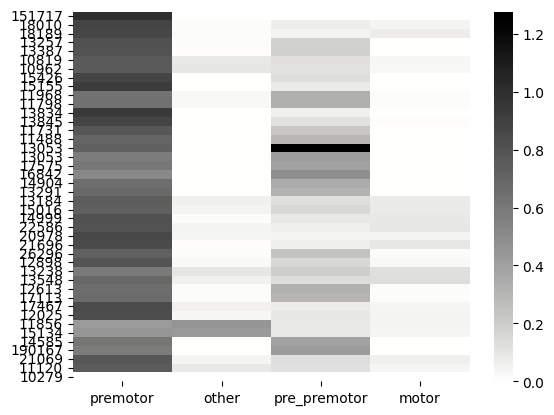

In [26]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = source_ids,
            xticklabels = neuron_types,
            cmap = cmap)
plt.show()

In [27]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [28]:
# Sort connectivity matrix 
neuron_names = list(dict_ids.keys())

# Sort rows based on clustering in manc_neuropil_analysis.ipynb
sort_index = [0,2,5,16,20,14,17,1,4,13,6,7,12,3,11,15,18,8,19,9,10]
connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
neuron_names = [neuron_names[i] for i in sort_index]

# Sort columns
sort_list = ['motor','premotor','pre_premotor','other']
sort_index = [neuron_types.index(i) for i in sort_list]
connectivity_matrix = connectivity_matrix[:, [i for i in sort_index]]
neuron_types = [neuron_types[i] for i in sort_index]

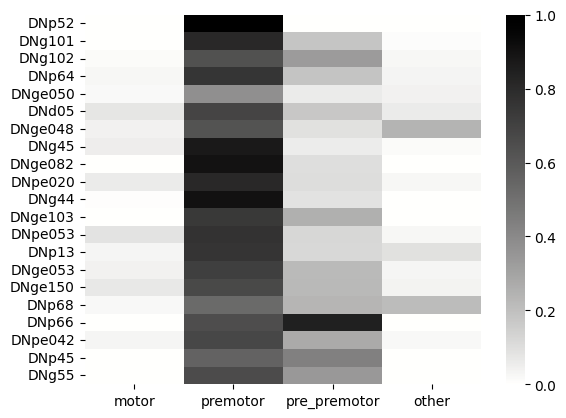

In [34]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = neuron_types,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()# Plot connectivity matrix

In [31]:
# Compute mean output per neuropil per cluster
clusters = [[1,2,3,4,5,6,7,8,9,10,11], [12,13,14,15,16,17,18,19,20]]
cluster_means = np.zeros((len(clusters),len(neuron_types)))
for cluster_index, cluster in enumerate(clusters):
    cluster_means[cluster_index,:] = np.mean(connectivity_matrix[cluster,:],axis=0)

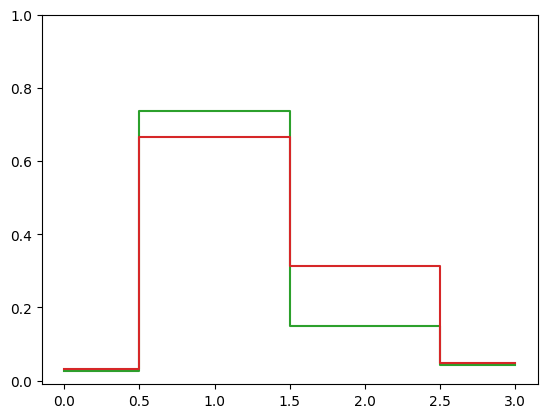

In [33]:
# Plot means
colors = ['tab:green','tab:red']
for cluster_index, _ in enumerate(clusters):
    plt.step(range(len(cluster_means[cluster_index,:])),cluster_means[cluster_index,:], color=colors[cluster_index], where='mid')

plt.ylim([-0.01,1])
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()